# Feature exploration

In [1]:
import os
import getpass

import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from s3fs import S3FileSystem
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 3
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [6]:
AWS_ACCESS_KEY_ID = getpass.getpass()
AWS_SECRET_KEY = getpass.getpass()

 ····················
 ········································


In [7]:
s3_filesystem = S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_KEY
)

## Load FFS data

In [8]:
ffs_all_data_1718 = pq.read_table(
    f"s3://fantasy-football-scout/processed/fantasy_football_scout_all_features_1718_to_1819.parquet", 
    filesystem=s3_filesystem
).to_pandas()

print(ffs_all_data_1718.shape)
ffs_all_data_1718.head()

(20449, 308)


,Name,Team,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,position,full_name,season,gw,Attempts From Set Plays Conceded,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Conceded,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Conceded (Centre Zone),Chances Conceded (Left Zone),Chances Conceded (Right Zone),Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Percentage Centre Zone),Chances Created (Percentage Left Zone),Chances Created (Percentage Right Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Percentage Left Zone),Crosses - Opponents Half (Percentage Right Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses Conceded (Left Zone),Crosses Conceded (Right Zone),Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Games Played,Goal Attempts,Goal Attempts Conceded,Goal Attempts In Box Conceded,Goal Attempts Outside Box Conceded,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goal Attempts Conceded,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Big Chance,Minutes Per Big Chance Conceded,Minutes Per Block,Minutes Per Chance,Minutes Per Chance Conceded,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xG Conceded,Minutes Per xG On Target Conceded,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Open Play Goal Attempts,Open Play Goal Attempts Conceded,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - 

In [9]:
ffs_all_data_1718.drop(columns=['Name', 'full_name'], inplace=True)

### Deal with nulls and inf values

inf

In [10]:
columns_with_inf = []
for col in ffs_all_data_1718.columns:
    if np.inf in ffs_all_data_1718[col].values:
        print(col)
        print(ffs_all_data_1718[ffs_all_data_1718['Minutes Per xA'] == np.inf].shape[0] / ffs_all_data_1718.shape[0])
        columns_with_inf.append(col)
        print('\n')

Minutes Per xA
0.30275319086507896


Minutes Per xG
0.30275319086507896


Minutes Per xGI
0.30275319086507896


Minutes Per xGP
0.30275319086507896


Sky Minutes Per Bonus
0.30275319086507896




Looks like `inf` caused by divide by zero error. For now let's impute with 0 but if these features are shown to be predictive then may need to revisit this. Could use a very large number instead.

In [11]:
for col in columns_with_inf:
    ffs_all_data_1718[col].replace({np.inf: 0}, inplace=True)

nan

In [12]:
ffs_all_data_1718.replace({'nan': np.nan}, inplace=True)

### Drop features with all nulls

In [13]:
ffs_all_data_1718.dropna(axis=1, how='all', inplace=True)

In [15]:
ffs_all_data_1718.head()

,Team,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,position,season,gw,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties 

## Questions

In [106]:
FEATURES_TO_DROP = []

### `Overall Points`, `Starts`, `Appearances`

In [107]:
ffs_all_data_1718.groupby('name')['Overall Points'].nunique().max()

1

In [108]:
ffs_all_data_1718.groupby('name')['Starts'].nunique().max()

3

In [109]:
ffs_all_data_1718.groupby('name')['Appearances'].nunique().max()

2

2 for double gameweeks

In [110]:
FEATURES_TO_DROP += ['Overall Points', 'Starts', 'Appearances']

### BPS features

In [111]:
bps_features = [feature for feature in ffs_all_data_1718.columns if 'BPS' in feature]
bps_features

['BPS Baseline',
 'BPS CBI',
 'BPS Clean Sheets',
 'BPS Goals',
 'BPS Pass Completion',
 'BPS Recoveries',
 'BPS Time Played',
 'BPS Yellow Cards',
 'Minutes Per Baseline BPS']

In [112]:
ffs_all_data_1718[ffs_all_data_1718['BPS Clean Sheets'] != 0][['Clean Sheets', 'BPS Clean Sheets']].head(10)

,Clean Sheets,BPS Clean Sheets
3222,1,12
3224,1,12
3226,1,12
3227,1,12
3232,1,12
3233,1,12
3234,1,12
3236,1,12
3242,1,12
3245,1,12


BPS features are just the points breakdown of total BPS. Each feature is a scalar of another feature according to the BPS rules.

In [113]:
FEATURES_TO_DROP += bps_features

### Different measures of time

In [114]:
ffs_all_data_1718[['Time Played', 'BPS Time Played', 'Exact Time Played']].sample(n=10)

,Time Played,BPS Time Played,Exact Time Played
11265,90,6,94
19487,86,6,85
20433,90,6,95
10627,90,6,99
10258,90,6,94
18325,90,6,92
19689,21,3,24
8810,90,6,93
2935,6,3,9
9591,10,3,14


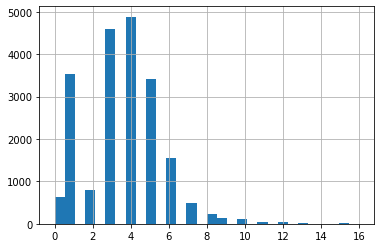

In [115]:
np.abs(ffs_all_data_1718['Time Played'] - ffs_all_data_1718['Exact Time Played']).hist(bins=30)
plt.show()

In [116]:
fpl_data = pd.read_parquet('data/processed/fpl_data_2016_to_2019.parquet')

In [117]:
fpl_vardy_mins = fpl_data[(fpl_data['name'] == 'jamie_vardy') & (fpl_data['season'] == '2018-19')][['gw', 'minutes']]
fpl_vardy_mins.head()

,gw,minutes
54810,1,27
54811,2,65
54812,3,0
54813,4,0
54814,5,83


In [118]:
ffs_vardy_mins = ffs_all_data_1718[
    (ffs_all_data_1718['name'] == 'jamie_vardy') & 
    (ffs_all_data_1718['season'] == '2018-2019')
][['gw', 'Exact Time Played', 'Time Played']]

ffs_vardy_mins.head()

,gw,Exact Time Played,Time Played
1649,1,31,27
1696,10,52,45
1739,11,95,90
1774,12,93,90
1813,13,39,34


In [119]:
comp = fpl_vardy_mins.merge(ffs_vardy_mins, on='gw', how='left')
comp.head()

,gw,minutes,Exact Time Played,Time Played
0,1,27,31.0,27.0
1,2,65,65.0,66.0
2,3,0,NaN,NaN
3,4,0,NaN,NaN
4,5,83,83.0,84.0


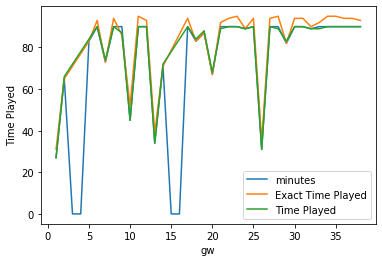

In [120]:
sns.lineplot(x='gw', y='minutes', data=comp, label='minutes')
sns.lineplot(x='gw', y='Exact Time Played', data=comp, label='Exact Time Played')
sns.lineplot(x='gw', y='Time Played', data=comp, label='Time Played')
plt.legend()
plt.show()

In [121]:
np.abs(comp['minutes'] - comp['Time Played'].fillna(0)).sum()

14.0

In [122]:
np.abs(comp['minutes'] - comp['Exact Time Played'].fillna(0)).sum()

99.0

Both measures don't seem to align with FPL exactly but `Time Played` is closer so we keep this.

In [123]:
FEATURES_TO_DROP += ['Exact Time Played']

### `Ownership`

In [124]:
ffs_all_data_1718.groupby('name')['Ownership'].nunique().max()

1

In [125]:
FEATURES_TO_DROP += ['Ownership']

### Any other features which are static?

In [126]:
ffs_all_data_1718.head()

,Team,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,position,season,gw,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties 

In [127]:
binary_features = []
for feature in ffs_all_data_1718.columns:
    if sorted(ffs_all_data_1718[feature].unique()) == [0, 1]:
        print(feature)
        binary_features.append(feature)

Attempts From Direct Free-kick
Goals From Direct Free-kick
Goals From Throw-in
Own Goals
Penalties Missed
Premier League Straight Red Cards
Premier League Total Red Cards
Saves From Penalty
Second Yellow Cards
Shots - Long - Attempts
Shots - Long - On Target
Sky Bonus Shots Tier 1
Sky Bonus Shots Tier 2
Sky Bonus Tackles Tier 1
Sky Bonus Tackles Tier 2
Winning Goal


Some of these not necessarily binary but unlikely to occur more than once e.g. Own Goals

Subbed On


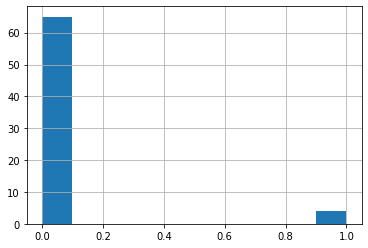

Clean Sheets


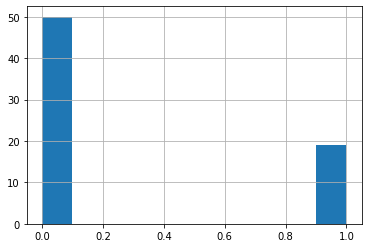

Sky Bonus Saves Tier 2


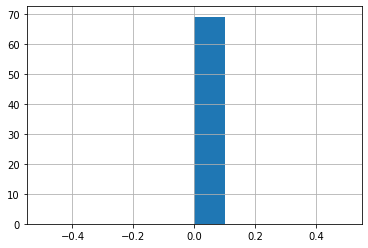

position


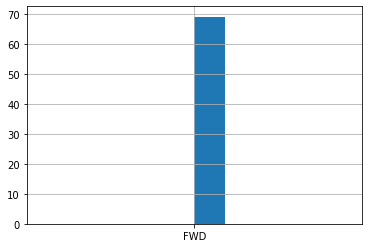

Headed Goals


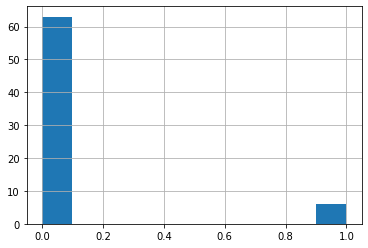

Key Contributions


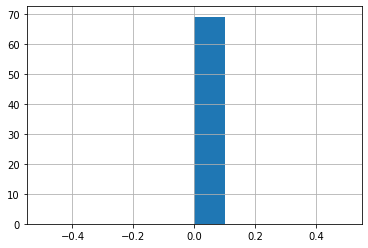

Errors Leading to Goal


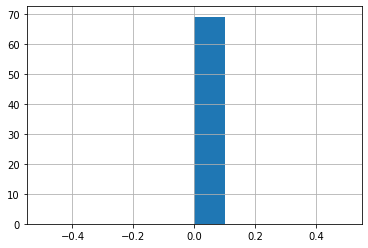

Saves - Unclaimed Crosses


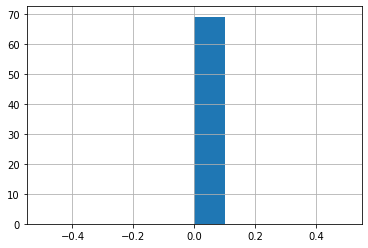

Goals From Set Plays


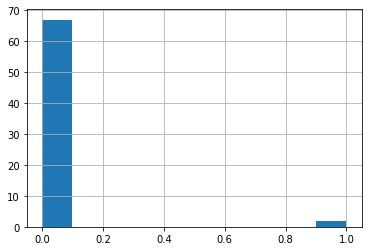

Goals From Counter Attack


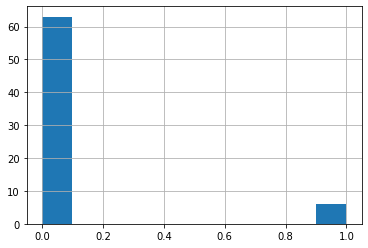

Sky Bonus Saves Tier 1


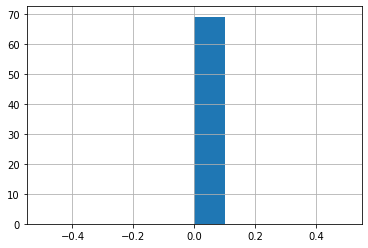

Penalties Conceded


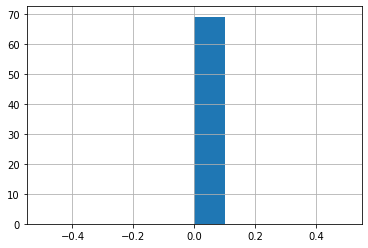

name


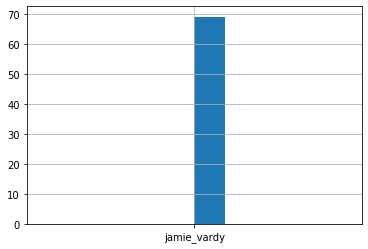

Subbed Off


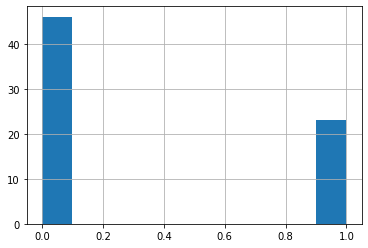

Solo Goals


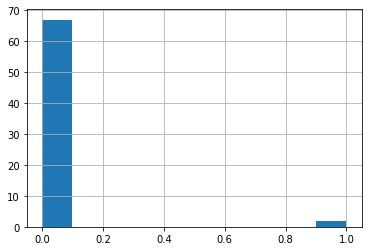

Penalties Faced


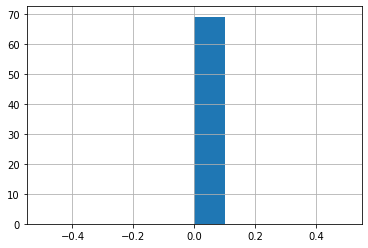

Sky Bonus Passes Tier 2


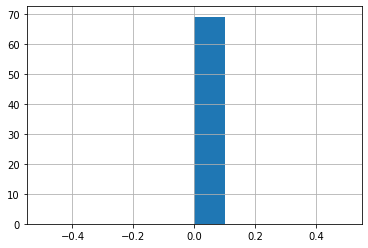

Clearances - Unsuccessful


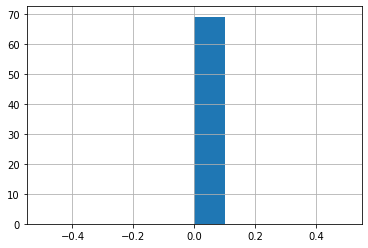

Sky Bonus Passes Tier 1


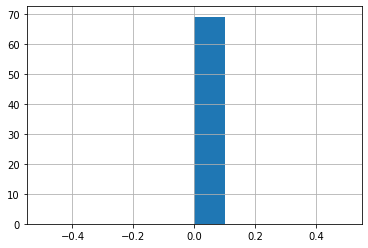

Team


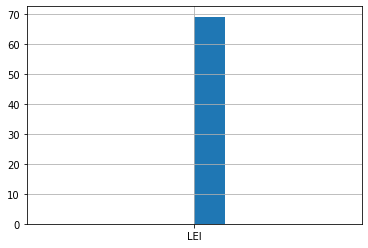

Big Chances Missed Ball


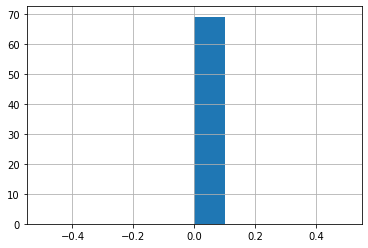

Goals From Indirect Free-kick


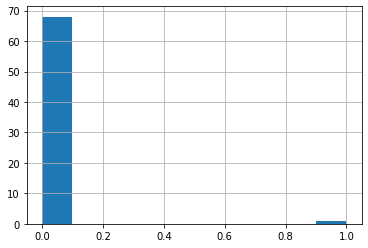

Tricks


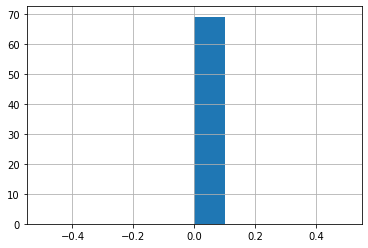

Goals From Penalties


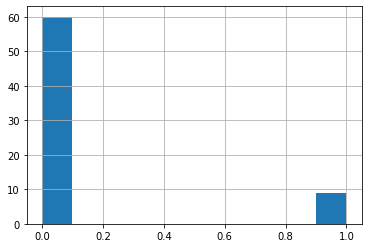

Goals From Outside Box


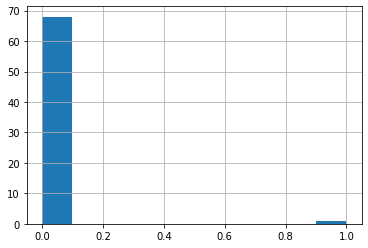

Goals From Direct Corners


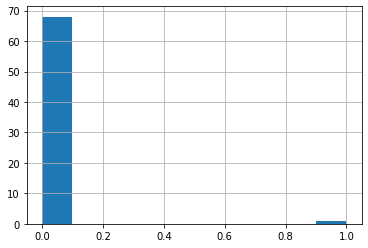

Bonus Points


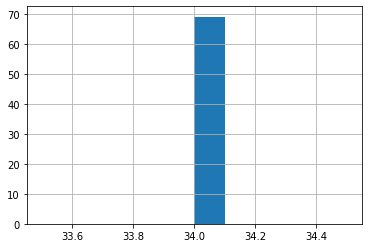

season


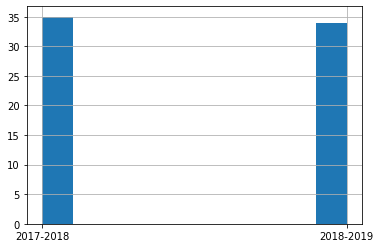

Attempts from Throw-in


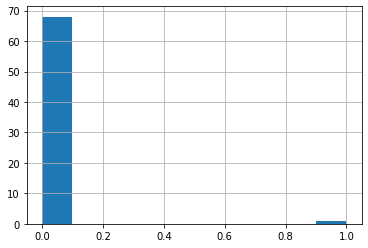

Hit Woodwork


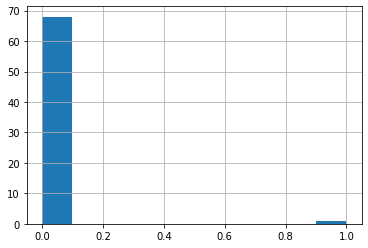

Attempts From Indirect Free-kick


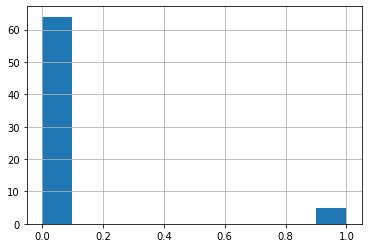

Errors Leading to Chance


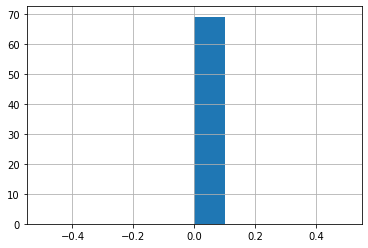

Premier League Yellow Cards


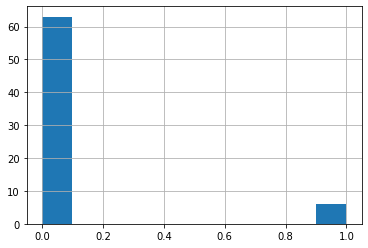

Chances Missed


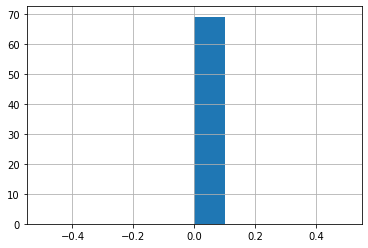

Fantasy Assists


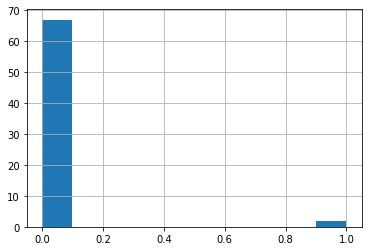

Shots - Six Yard Box - On Target


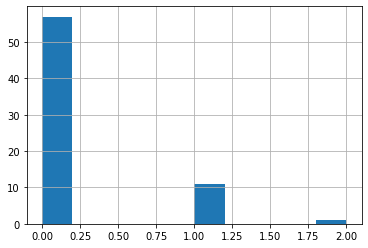

Handballs


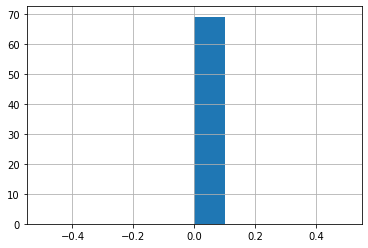

Missed Opportunities


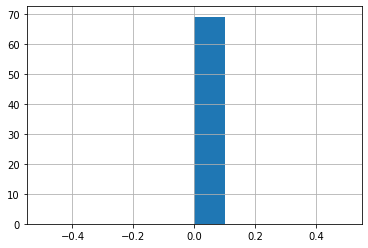

In [128]:
for feature in set(ffs_all_data_1718.columns) - set(FEATURES_TO_DROP) - set(binary_features):
    if ffs_all_data_1718.groupby('name')[feature].nunique().max() <= 3:
        print(feature)
        ffs_all_data_1718[ffs_all_data_1718['name'] == 'jamie_vardy'][feature].hist()
        plt.show()

`Bonus Points` seems like the other main 'static' feature

In [129]:
FEATURES_TO_DROP.append('Bonus Points')

In [130]:
FEATURES_TO_DROP

['Overall Points',
 'Starts',
 'Appearances',
 'BPS Baseline',
 'BPS CBI',
 'BPS Clean Sheets',
 'BPS Goals',
 'BPS Pass Completion',
 'BPS Recoveries',
 'BPS Time Played',
 'BPS Yellow Cards',
 'Minutes Per Baseline BPS',
 'Exact Time Played',
 'Ownership',
 'Bonus Points']